In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import wandb

['00', '01', '04', '05', '06', '08', '09', '11', '12', '13', '14', '15', '16', '18', '19', '20', '21', '23', '24', '26', '28', '29', '30', '31', '33', '35', '37', '38', '41', '42', '43', '44', '45', '50', '51', '53', '54', '56', '59', '60', '62', '63', '65', '69', '70', '72', '74', '75', '76', '77', '79', '81', '82', '84', '85', '87', '88', '89', '90', '91', '94', '95', '97', '98']
Dataset CustomImageFolder
    Number of datapoints: 64000
    Root location: double_mnist/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
['03', '07', '10', '22', '27', '34', '39', '40', '48', '52', '58', '61', '64', '71', '93', '99']
tensor([72, 81, 14, 50, 37, 94, 18, 69, 24, 89, 91, 19, 42, 62, 75, 23, 85, 62,
        37, 12, 42, 30, 63, 63, 77, 70, 90, 15, 76, 30,  1, 65, 26, 69,

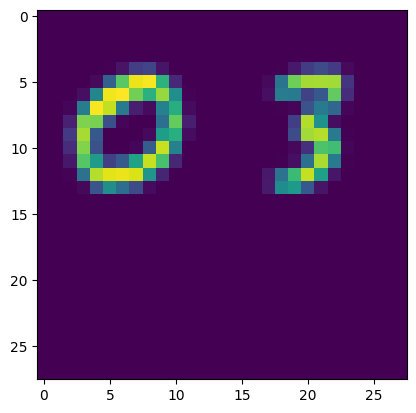

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data_path = 'double_mnist/train'
val_data_path = 'double_mnist/val'
test_data_path = 'double_mnist/test'
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        folder_name = os.path.basename(os.path.dirname(path))
        return sample, int(folder_name)  
train_dataset = CustomImageFolder(train_data_path, transform=transform)
val_dataset = CustomImageFolder(val_data_path, transform=transform)
test_dataset = CustomImageFolder(test_data_path, transform=transform)
print(train_dataset.classes)
class_to_label = {str(i).zfill(2): i for i in range(100)}
batch_size = 64
print(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = 10

class_names = train_dataset.classes
class_names = val_dataset.classes

print(class_names)

for images, labels in train_loader:
    print(labels)
    break
for images, labels in val_loader:
    plt.imshow(images[0].permute(1, 2, 0))
    print(labels[0])
    print(labels)
    break




In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_classes, kernel_size=3, pool_size=2, stride=2, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=kernel_size, padding=int((kernel_size - 1) / 2))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size - 1) / 2))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        var1 = int((28 - pool_size) / stride) + 1
        self.dim = int((var1 - pool_size) / stride) + 1
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN(input_channels=1, num_classes=num_classes)
model1 = SimpleCNN(input_channels=1, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)

In [19]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    cnt = 0
    for images, labels in train_loader:
        labels1 = labels//10
        labels2 = labels%10
        # class_names = train_dataset.classes
        optimizer1.zero_grad()
        optimizer.zero_grad()
        image = images.clone()
        image1 = images.clone()
        left_half = images[:, :, :, :images.shape[3] // 2]
        # print(left_half.shape)
        image[:, :, :, (image.shape[3] // 2):] = left_half
        right_half = images[:, :, :, images.shape[3] // 2 :]
        image1[:, :, :, :(image1.shape[3] // 2)] = right_half
        # print(images.shape)
        outputs = model(image)
        outputs1 = model1(image1)
        loss = criterion(outputs, labels1)
        loss1 = criterion1(outputs1,labels2)
        loss.backward()
        loss1.backward()
        optimizer.step()
        optimizer1.step()
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, predicted1 = torch.max(outputs1.data, 1)
        total_train += 2*labels.size(0)
        for i in range(labels.size(0)):
            # cnt += 1
            # if(cnt == 10):
            #     print(predicted[i])
            #     print(predicted1[i])
            #     print(labels[i])
            #     cnt=0
            #     break
            if(predicted[i] == labels[i]//10):
                correct_train += 1
            if(predicted1[i] == labels[i]%10):
                correct_train += 1
        # cnt += 1
        # if(cnt == 10):
        #     break
    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {average_train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
    model.eval()
    model1.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in val_loader:
            labels1 = labels // 10
            labels2 = labels % 10
            image = images.clone()
            image1 = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            right_half = images[:, :, :, images.shape[3] // 2 :]
            image1[:, :, :, :(image1.shape[3] // 2)] = right_half
            outputs = model(image)
            outputs1 = model1(image1)
            loss = criterion(outputs, labels1)
            loss1 = criterion1(outputs1,labels2)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            total_val += 2*labels.size(0)
            for i in range(labels.size(0)):
                if(predicted[i] == labels[i]//10):
                    correct_val += 1
                if(predicted1[i] == labels[i]%10):
                    correct_val += 1
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Loss: {average_val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%')
    model.eval()
    model1.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels1 = labels // 10
            labels2 = labels % 10
            image = images.clone()
            image1 = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            right_half = images[:, :, :, images.shape[3] // 2 :]
            image1[:, :, :, :(image1.shape[3] // 2)] = right_half
            outputs = model(image)
            outputs1 = model1(image1)
            loss = criterion(outputs, labels1)
            loss1 = criterion1(outputs1,labels2)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            total_val += 2*labels.size(0)
            for i in range(labels.size(0)):
                if(predicted[i] == labels[i]//10):
                    correct_val += 1
                if(predicted1[i] == labels[i]%10):
                    correct_val += 1
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Testing Loss: {average_val_loss:.4f} - Testing Accuracy: {val_accuracy:.2f}%')


Epoch 1/5 - Train Loss: 0.1039 - Train Accuracy: 96.81%
Epoch 1/5 - Validation Loss: 0.0837 - Validation Accuracy: 97.25%
Epoch 1/5 - Testing Loss: 0.0879 - Testing Accuracy: 97.08%
Epoch 2/5 - Train Loss: 0.0867 - Train Accuracy: 98.02%
Epoch 2/5 - Validation Loss: 0.0832 - Validation Accuracy: 97.44%
Epoch 2/5 - Testing Loss: 0.0866 - Testing Accuracy: 97.42%
Epoch 3/5 - Train Loss: 0.0796 - Train Accuracy: 98.25%
Epoch 3/5 - Validation Loss: 0.0773 - Validation Accuracy: 97.48%
Epoch 3/5 - Testing Loss: 0.0819 - Testing Accuracy: 97.59%
Epoch 4/5 - Train Loss: 0.0728 - Train Accuracy: 98.42%
Epoch 4/5 - Validation Loss: 0.0863 - Validation Accuracy: 97.60%
Epoch 4/5 - Testing Loss: 0.0932 - Testing Accuracy: 97.58%
Epoch 5/5 - Train Loss: 0.0635 - Train Accuracy: 98.62%
Epoch 5/5 - Validation Loss: 0.0839 - Validation Accuracy: 97.74%
Epoch 5/5 - Testing Loss: 0.0784 - Testing Accuracy: 97.82%


In [4]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lsamourya07 (mourya). Use `wandb login --relogin` to force relogin


True

In [5]:
# learning_rates = [0.001,0.01]
# dropout_rates = [0.5,0.3]
# kernel_sizes = [3,5]
sweep_config = {
    "name": "5.1-CNN Hyperparameter Tuning",
    "method": "grid",
    "parameters": {
        "learning_rate": {"values": [0.001, 0.01]},
        "dropout_rate": {"values": [0.5, 0.3]},
        "kernel_size": {"values": [3, 5]}
    },
    "metric": {"goal": "maximize", "name": "test_accuracy"},
}
sweep_id = wandb.sweep(sweep_config, project="5.1-CNN Hyperparameter Tuning")

def train():
    wandb.init(project="5.1-CNN Hyperparameter Tuning")
    lrate = wandb.config.learning_rate
    dropout_rate = wandb.config.dropout_rate
    kernel_size = wandb.config.kernel_size
    num_epochs = 3
    num_classes = 10
    model = SimpleCNN(input_channels=1, num_classes=num_classes, kernel_size=kernel_size, dropout_rate=dropout_rate)
    model1 = SimpleCNN(input_channels=1, num_classes=num_classes, kernel_size=kernel_size, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lrate)
    criterion1 = nn.CrossEntropyLoss()
    optimizer1 = torch.optim.Adam(model1.parameters(), lr=lrate)
    num_epochs = 3
    print(lrate)
    train_accuracy = 0.0
    val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        cnt = 0
        for images, labels in train_loader:
            labels1 = labels//10
            labels2 = labels%10
            # class_names = train_dataset.classes
            optimizer1.zero_grad()
            optimizer.zero_grad()
            image = images.clone()
            image1 = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            # print(left_half.shape)
            image[:, :, :, (image.shape[3] // 2):] = left_half
            right_half = images[:, :, :, images.shape[3] // 2 :]
            image1[:, :, :, :(image1.shape[3] // 2)] = right_half
            # print(images.shape)
            outputs = model(image)
            outputs1 = model1(image1)
            loss = criterion(outputs, labels1)
            loss1 = criterion1(outputs1,labels2)
            loss.backward()
            loss1.backward()
            optimizer.step()
            optimizer1.step()
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            total_train += 2*labels.size(0)
            for i in range(labels.size(0)):
                # cnt += 1
                # if(cnt == 10):
                #     print(predicted[i])
                #     print(predicted1[i])
                #     print(labels[i])
                #     cnt=0
                #     break
                if(predicted[i] == labels[i]//10):
                    correct_train += 1
                if(predicted1[i] == labels[i]%10):
                    correct_train += 1
            # cnt += 1
            # if(cnt == 10):
            #     break
        train_accuracy = 100 * correct_train / total_train
        average_train_loss = total_train_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs} - Kernel Size: {kernel_size} - Dropout Rate: {dropout_rate} - Learning Rate - {lrate:.3f} - Train Accuracy: {train_accuracy:.2f}%')
        model.eval()
        model1.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        cnt = 0
        with torch.no_grad():
            for images, labels in test_loader:
                labels1 = labels // 10
                labels2 = labels % 10
                image = images.clone()
                image1 = images.clone()
                left_half = images[:, :, :, :images.shape[3] // 2]
                image[:, :, :, (image.shape[3] // 2):] = left_half
                right_half = images[:, :, :, images.shape[3] // 2 :]
                image1[:, :, :, :(image1.shape[3] // 2)] = right_half
                outputs = model(image)
                outputs1 = model1(image1)
                loss = criterion(outputs, labels1)
                loss1 = criterion1(outputs1,labels2)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                _, predicted1 = torch.max(outputs1.data, 1)
                total_val += 2*labels.size(0)
                for i in range(labels.size(0)):
                    if(predicted[i] == labels[i]//10):
                        correct_val += 1
                    if(predicted1[i] == labels[i]%10):
                        correct_val += 1
        val_accuracy = 100 * correct_val / total_val
        average_val_loss = total_val_loss / len(test_loader)
        print(f'Epoch {epoch + 1}/{num_epochs} - Testing Loss: {average_val_loss:.4f} - Testing Accuracy: {val_accuracy:.2f}%')
    wandb.log({
        "train_accuracy": train_accuracy,
        "test_accuracy": val_accuracy,
    })

wandb.agent(sweep_id, function=train)

     
  


Create sweep with ID: k47gnuar
Sweep URL: https://wandb.ai/mourya/5.1-CNN%20Hyperparameter%20Tuning/sweeps/k47gnuar


wandb: Agent Starting Run: z58oxos9 with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001
Epoch 1/3 - Kernel Size: 3 - Dropout Rate: 0.5 - Learning Rate - 0.001 - Train Accuracy: 74.67%
Epoch 1/3 - Testing Loss: 0.2017 - Testing Accuracy: 93.19%
Epoch 2/3 - Kernel Size: 3 - Dropout Rate: 0.5 - Learning Rate - 0.001 - Train Accuracy: 93.83%
Epoch 2/3 - Testing Loss: 0.1475 - Testing Accuracy: 95.59%
Epoch 3/3 - Kernel Size: 3 - Dropout Rate: 0.5 - Learning Rate - 0.001 - Train Accuracy: 95.76%
Epoch 3/3 - Testing Loss: 0.1160 - Testing Accuracy: 96.46%


test_accuracy,▁
train_accuracy,▁
test_accuracy,96.4575
train_accuracy,95.76094


wandb: Agent Starting Run: l5d7fgjd with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01
Epoch 1/3 - Kernel Size: 3 - Dropout Rate: 0.5 - Learning Rate - 0.010 - Train Accuracy: 69.86%
Epoch 1/3 - Testing Loss: 0.4168 - Testing Accuracy: 87.18%
Epoch 2/3 - Kernel Size: 3 - Dropout Rate: 0.5 - Learning Rate - 0.010 - Train Accuracy: 87.94%
Epoch 2/3 - Testing Loss: 0.3138 - Testing Accuracy: 90.71%
Epoch 3/3 - Kernel Size: 3 - Dropout Rate: 0.5 - Learning Rate - 0.010 - Train Accuracy: 89.46%
Epoch 3/3 - Testing Loss: 0.3399 - Testing Accuracy: 91.44%


test_accuracy,▁
train_accuracy,▁
test_accuracy,91.445
train_accuracy,89.45547


wandb: Agent Starting Run: 437pb32v with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001
Epoch 1/3 - Kernel Size: 5 - Dropout Rate: 0.5 - Learning Rate - 0.001 - Train Accuracy: 77.51%
Epoch 1/3 - Testing Loss: 0.1777 - Testing Accuracy: 94.76%
Epoch 2/3 - Kernel Size: 5 - Dropout Rate: 0.5 - Learning Rate - 0.001 - Train Accuracy: 94.71%
Epoch 2/3 - Testing Loss: 0.1249 - Testing Accuracy: 96.34%
Epoch 3/3 - Kernel Size: 5 - Dropout Rate: 0.5 - Learning Rate - 0.001 - Train Accuracy: 96.36%
Epoch 3/3 - Testing Loss: 0.1156 - Testing Accuracy: 96.60%


test_accuracy,▁
train_accuracy,▁
test_accuracy,96.6025
train_accuracy,96.35547


wandb: Agent Starting Run: 61d26nx4 with config:
wandb: 	dropout_rate: 0.5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01
Epoch 1/3 - Kernel Size: 5 - Dropout Rate: 0.5 - Learning Rate - 0.010 - Train Accuracy: 84.00%
Epoch 1/3 - Testing Loss: 0.2241 - Testing Accuracy: 93.27%
Epoch 2/3 - Kernel Size: 5 - Dropout Rate: 0.5 - Learning Rate - 0.010 - Train Accuracy: 93.40%
Epoch 2/3 - Testing Loss: 0.3127 - Testing Accuracy: 93.11%
Epoch 3/3 - Kernel Size: 5 - Dropout Rate: 0.5 - Learning Rate - 0.010 - Train Accuracy: 93.50%
Epoch 3/3 - Testing Loss: 0.2239 - Testing Accuracy: 94.25%


test_accuracy,▁
train_accuracy,▁
test_accuracy,94.255
train_accuracy,93.50312


wandb: Agent Starting Run: wi3ci0hp with config:
wandb: 	dropout_rate: 0.3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001
Epoch 1/3 - Kernel Size: 3 - Dropout Rate: 0.3 - Learning Rate - 0.001 - Train Accuracy: 76.60%
Epoch 1/3 - Testing Loss: 0.2744 - Testing Accuracy: 92.39%
Epoch 2/3 - Kernel Size: 3 - Dropout Rate: 0.3 - Learning Rate - 0.001 - Train Accuracy: 93.79%
Epoch 2/3 - Testing Loss: 0.1654 - Testing Accuracy: 95.42%
Epoch 3/3 - Kernel Size: 3 - Dropout Rate: 0.3 - Learning Rate - 0.001 - Train Accuracy: 95.66%
Epoch 3/3 - Testing Loss: 0.1321 - Testing Accuracy: 96.02%


test_accuracy,▁
train_accuracy,▁
test_accuracy,96.0225
train_accuracy,95.6625


wandb: Agent Starting Run: hdaa2cqw with config:
wandb: 	dropout_rate: 0.3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01
Epoch 1/3 - Kernel Size: 3 - Dropout Rate: 0.3 - Learning Rate - 0.010 - Train Accuracy: 40.72%
Epoch 1/3 - Testing Loss: 2.3522 - Testing Accuracy: 42.32%
Epoch 2/3 - Kernel Size: 3 - Dropout Rate: 0.3 - Learning Rate - 0.010 - Train Accuracy: 50.80%
Epoch 2/3 - Testing Loss: 2.3572 - Testing Accuracy: 47.92%
Epoch 3/3 - Kernel Size: 3 - Dropout Rate: 0.3 - Learning Rate - 0.010 - Train Accuracy: 51.73%
Epoch 3/3 - Testing Loss: 2.3588 - Testing Accuracy: 47.05%


test_accuracy,▁
train_accuracy,▁
test_accuracy,47.05
train_accuracy,51.73203


wandb: Agent Starting Run: 41pj7j8a with config:
wandb: 	dropout_rate: 0.3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.001
Epoch 1/3 - Kernel Size: 5 - Dropout Rate: 0.3 - Learning Rate - 0.001 - Train Accuracy: 80.31%
Epoch 1/3 - Testing Loss: 0.1691 - Testing Accuracy: 94.03%
Epoch 2/3 - Kernel Size: 5 - Dropout Rate: 0.3 - Learning Rate - 0.001 - Train Accuracy: 95.24%
Epoch 2/3 - Testing Loss: 0.1146 - Testing Accuracy: 96.17%
Epoch 3/3 - Kernel Size: 5 - Dropout Rate: 0.3 - Learning Rate - 0.001 - Train Accuracy: 96.68%
Epoch 3/3 - Testing Loss: 0.0978 - Testing Accuracy: 96.86%


test_accuracy,▁
train_accuracy,▁
test_accuracy,96.8575
train_accuracy,96.68203


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mqrttt5y with config:
wandb: 	dropout_rate: 0.3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


0.01
Epoch 1/3 - Kernel Size: 5 - Dropout Rate: 0.3 - Learning Rate - 0.010 - Train Accuracy: 85.50%
Epoch 1/3 - Testing Loss: 0.2038 - Testing Accuracy: 94.63%
Epoch 2/3 - Kernel Size: 5 - Dropout Rate: 0.3 - Learning Rate - 0.010 - Train Accuracy: 94.09%
Epoch 2/3 - Testing Loss: 0.2288 - Testing Accuracy: 94.00%
Epoch 3/3 - Kernel Size: 5 - Dropout Rate: 0.3 - Learning Rate - 0.010 - Train Accuracy: 94.46%
Epoch 3/3 - Testing Loss: 0.2641 - Testing Accuracy: 93.05%


test_accuracy,▁
train_accuracy,▁
test_accuracy,93.045
train_accuracy,94.46484


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# 5.1.3 (Testing on Regular MNIST)

In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
total_size = len(trainset)
train_size = int(0.8 * total_size)
validation_size = int(0.1 * total_size)
test_size = total_size - train_size - validation_size

# Split the dataset
gen = torch.Generator().manual_seed(42)
train_set, validation_set, test_set = random_split(trainset, [train_size, validation_size, test_size],generator=gen)

# Create data loaders for each set
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,generator=gen)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
model = SimpleCNN(input_channels=1, num_classes=num_classes)
model1 = SimpleCNN(input_channels=1, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    cnt = 0
    for images, labels in train_loader:
        labels1 = labels//10
        labels2 = labels%10
        # class_names = train_dataset.classes
        optimizer1.zero_grad()
        optimizer.zero_grad()
        image = images.clone()
        image1 = images.clone()
        left_half = images[:, :, :, :images.shape[3] // 2]
        # print(left_half.shape)
        image[:, :, :, (image.shape[3] // 2):] = left_half
        right_half = images[:, :, :, images.shape[3] // 2 :]
        image1[:, :, :, :(image1.shape[3] // 2)] = right_half
        # print(images.shape)
        outputs = model(image)
        outputs1 = model1(image1)
        loss = criterion(outputs, labels1)
        loss1 = criterion1(outputs1,labels2)
        loss.backward()
        loss1.backward()
        optimizer.step()
        optimizer1.step()
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, predicted1 = torch.max(outputs1.data, 1)
        total_train += 2*labels.size(0)
        for i in range(labels.size(0)):
            # cnt += 1
            # if(cnt == 10):
            #     print(predicted[i])
            #     print(predicted1[i])
            #     print(labels[i])
            #     cnt=0
            #     break
            if(predicted[i] == labels[i]//10):
                correct_train += 1
            if(predicted1[i] == labels[i]%10):
                correct_train += 1
        # cnt += 1
        # if(cnt == 10):
        #     break
    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {average_train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
    model.eval()
    model1.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    cnt = 0
    with torch.no_grad():
        for images, labels in testloader:
            labels1 = labels // 10
            labels2 = labels % 10
            image = images.clone()
            image1 = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            right_half = images[:, :, :, images.shape[3] // 2 :]
            image1[:, :, :, :(image1.shape[3] // 2)] = right_half
            outputs = model(image)
            outputs1 = model1(image1)
            loss = criterion(outputs, labels1)
            loss1 = criterion1(outputs1,labels2)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, predicted1 = torch.max(outputs1.data, 1)
            total_val += 2*labels.size(0)
            for i in range(labels.size(0)):
                if(predicted[i] == labels[i]//10):
                    correct_val += 1
                if(predicted1[i] == labels[i]%10):
                    correct_val += 1
    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(testloader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Testing Loss: {average_val_loss:.4f} - Testing Accuracy: {val_accuracy:.2f}%')


Epoch 1/5 - Train Loss: 0.7236 - Train Accuracy: 74.60%
Epoch 1/5 - Testing Loss: 7.3984 - Testing Accuracy: 6.93%
Epoch 2/5 - Train Loss: 0.2365 - Train Accuracy: 94.18%
Epoch 2/5 - Testing Loss: 8.6644 - Testing Accuracy: 6.26%
Epoch 3/5 - Train Loss: 0.1629 - Train Accuracy: 96.03%
Epoch 3/5 - Testing Loss: 7.6402 - Testing Accuracy: 11.82%
Epoch 4/5 - Train Loss: 0.1320 - Train Accuracy: 96.85%
Epoch 4/5 - Testing Loss: 7.0875 - Testing Accuracy: 12.06%
Epoch 5/5 - Train Loss: 0.1095 - Train Accuracy: 97.42%
Epoch 5/5 - Testing Loss: 8.5333 - Testing Accuracy: 11.97%
